<font size=6>
    <b>Sentiment_Analysis.ipynb:</b> Sentiment Analysis with Pandas and Watson Natural Language Understanding
 </font>

# Introduction

With the significant growth in the volume of highly subjective user-generated text in the form of online products reviews, recommendations, blogs, discussion forums and etc., the sentiment analysis has gained a lot of attention in the last decade. The sentiment analysis goal is to automatically detect the underlying sentiment of the user towards the entity of interest. While the Sentiment analysis is  one of the most prominent and commonly used natural language processing (NLP) features, it is typically used in combination with other NLP features and text analytics to gain insight about the user experience for the sake of customer care and feedback analytics, product analytics and brand intelligence.
This notebook shows how the open source library [Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas) lets you use use [Pandas](https://pandas.pydata.org/) DataFrames and the [Watson Natural Language Understanding](https://www.ibm.com/cloud/watson-natural-language-understanding) service to conduct exploratory sentiment analysis over the product reviews. 

We start out with a dataset from the [Edmunds-Consumer Car Ratings and Reviews](https://www.kaggle.com/ankkur13/edmundsconsumer-car-ratings-and-reviews) obtained from the Kaggle datasets. This is a dataset containing consumer's thought and the star rating of car manufacturer/model/type.
We pass each review to the Watson Natural Language 
Understanding (NLU) service. Then we use Text Extensions for Pandas to convert the output of the 
Watson NLU service to Pandas DataFrames. Next, we perform an example exploratory data analysis and machine learning task with 
Pandas to show how Pandas makes analyzing the dataset and prediction task much easier.

# Environment Setup

This notebook requires a Python 3.7 or later environment with the following packages:
* The dependencies listed in the ["requirements.txt" file for Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas/blob/master/requirements.txt)
* The "[ibm-watson](https://pypi.org/project/ibm-watson/)" package, available via `pip install ibm-watson`
* `text_extensions_for_pandas`

You can satisfy the dependency on `text_extensions_for_pandas` in either of two ways:

* Run `pip install text_extensions_for_pandas` before running this notebook. This command adds the library to your Python environment.
* Run this notebook out of your local copy of the Text Extensions for Pandas project's [source tree](https://github.com/CODAIT/text-extensions-for-pandas). In this case, the notebook will use the version of Text Extensions for Pandas in your local source tree **if the package is not installed in your Python environment**.

In [1]:
# Core Python libraries
import json
import os
import sys
import pandas as pd
import numpy as np
import glob
import re
import time
import warnings
from typing import *

# IBM Watson libraries
import ibm_watson
import ibm_watson.natural_language_understanding_v1 as nlu
import ibm_cloud_sdk_core

# Machine Learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Visualization
import matplotlib.pyplot as plt


# And of course we need the text_extensions_for_pandas library itself.
try:
    import text_extensions_for_pandas as tp
except ModuleNotFoundError as e:
    # If we're running from within the project source tree and the parent Python
    # environment doesn't have the text_extensions_for_pandas package, use the
    # version in the local source tree.
    if not os.getcwd().endswith("notebooks"):
        raise e
    if ".." not in sys.path:
        sys.path.insert(0, "..")
    import text_extensions_for_pandas as tp

# Set up the Watson Natural Language Understanding Service

In this part of the notebook, we will use the Watson Natural Language Understanding (NLU) service to extract the keywords and their sentiment and emotion from each of the product reviews.

You can create an instance of Watson NLU on the IBM Cloud for free by navigating to [this page](https://www.ibm.com/cloud/watson-natural-language-understanding) and clicking on the button marked "Get started free". You can also install your own instance of Watson NLU on [OpenShift](https://www.openshift.com/) by using [IBM Watson Natural Language Understanding for IBM Cloud Pak for Data](
https://catalog.redhat.com/software/operators/detail/5e9873e13f398525a0ceafe5).

You'll need two pieces of information to access your instance of Watson NLU: An **API key** and a **service URL**. If you're using Watson NLU on the IBM Cloud, you can find your API key and service URL in the IBM Cloud web UI. Navigate to the [resource list](https://cloud.ibm.com/resources) and click on your instance of Natural Language Understanding to open the management UI for your service. Then click on the "Manage" tab to show a page with your API key and service URL.

The cell that follows assumes that you are using the environment variables `IBM_API_KEY` and `IBM_SERVICE_URL` to store your credentials. If you're running this notebook in Jupyter on your laptop, you can set these environment variables while starting up `jupyter notebook` or `jupyter lab`. For example:
``` console
IBM_API_KEY='<my API key>' \
IBM_SERVICE_URL='<my service URL>' \
  jupyter lab
```

Alternately, you can uncomment the first two lines of code below to set the `IBM_API_KEY` and `IBM_SERVICE_URL` environment variables directly.
**Be careful not to store your API key in any publicly-accessible location!**

In [2]:
# If you need to embed your credentials inline, uncomment the following two lines and
# paste your credentials in the indicated locations.
# os.environ["IBM_API_KEY"] = "<API key goes here>"
# os.environ["IBM_SERVICE_URL"] = "<Service URL goes here>"

# Retrieve the API key for your Watson NLU service instance
if "IBM_API_KEY" not in os.environ:
    raise ValueError("Expected Watson NLU api key in the environment variable 'IBM_API_KEY'")
api_key = os.environ.get("IBM_API_KEY")
    
# Retrieve the service URL for your Watson NLU service instance
if "IBM_SERVICE_URL" not in os.environ:
    raise ValueError("Expected Watson NLU service URL in the environment variable 'IBM_SERVICE_URL'")
service_url = os.environ.get("IBM_SERVICE_URL")  

# Connect to the Watson Natural Language Understanding Python API

This notebook uses the IBM Watson Python SDK to perform authentication on the IBM Cloud via the 
`IAMAuthenticator` class. See [the IBM Watson Python SDK documentation](https://github.com/watson-developer-cloud/python-sdk#iam) for more information. 

We start by using the API key and service URL from the previous cell to create an instance of the
Python API for Watson NLU.

In [3]:
natural_language_understanding = ibm_watson.NaturalLanguageUnderstandingV1(
    version="2019-07-12",
    authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key)
)
natural_language_understanding.set_service_url(service_url)
natural_language_understanding.set_disable_ssl_verification(True)

# Pass a Review through the Watson NLU Service

Once you've opened a connection to the Watson NLU service, you can pass documents through 
the service by invoking the [`analyze()` method](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#analyze).

To do so, you should download the [Edmunds-Consumer Car Ratings and Reviews](https://www.kaggle.com/ankkur13/edmundsconsumer-car-ratings-and-reviews/download/) from the Kaggle website and place the archive.zip folder to our notebooks/outputs directory. Note that the directory of the dataset contains 50 csv files of reviews of 50 major car brands which we read into one dataframe with the brand name is listed under the "Car_Make" column.

Let's read the reviews and show what the reviews looks like:

In [4]:
from zipfile import ZipFile
path = r'./outputs/archive' # path to compressed  directory of data

with ZipFile(path+'.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the notebooks/output/archive directory
   zipObj.extractall(path)
    
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=0, header=0, lineterminator='\n')
    df['Car_Make'] = re.split('_|\\.',os.path.basename(filename))[-2] # Extracting the car brand from file name
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame.head(10)

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r,Car_Make
0,on 09/18/11 00:19 AM (PDT),wizbang_fl,2007 Volkswagen New Beetle Convertible 2.5 2dr...,"New Beetle- Holds up well & Fun to Drive, but ...",I've had my Beetle Convertible for over 4.5 y...,4.500,Volkswagen
1,on 07/07/10 05:28 AM (PDT),carlo frazzano,2007 Volkswagen New Beetle Convertible 2.5 PZE...,Quality Review,We bought the car new in 2007 and are general...,4.375,Volkswagen
2,on 10/19/09 21:41 PM (PDT),NewBeetleDriver,2007 Volkswagen New Beetle Convertible Triple ...,Adore it,I adore my New Beetle. Even though I'm a male...,4.375,Volkswagen
3,on 01/01/09 19:13 PM (PST),Kayemtee,2007 Volkswagen New Beetle Convertible 2.5 2dr...,Nice Ragtop,My wife chose this car to replace a Sebring c...,4.375,Volkswagen
4,on 08/02/08 13:43 PM (PDT),jik,2007 Volkswagen New Beetle Convertible 2.5 2dr...,"Luv, luv, luv my dream car",4 of us carpool 1 way 30 min. Backseat ok fo...,4.750,Volkswagen
5,on 05/16/08 12:07 PM (PDT),Ray Cavanagh,2007 Volkswagen New Beetle Convertible Triple ...,The Best One So Far....,I owned a 2002 SLK and 2003 BMW Z-4. After s...,5.000,Volkswagen
6,on 03/28/08 22:04 PM (PDT),harvestmoon,2007 Volkswagen New Beetle Convertible 2.5 2dr...,Don't Fall Under The Cute Spell!,Fell in love with the car's look and would be...,2.750,Volkswagen
7,on 01/03/08 17:53 PM (PST),The Husband,2007 Volkswagen New Beetle Convertible Triple ...,Not for Cold Weather!!!,The car is beautiful and performs well in the...,3.750,Volkswagen
8,on 09/27/07 08:42 AM (PDT),Kristina,2007 Volkswagen New Beetle Convertible 2.5 2dr...,I love my Beetle,I love my car. I previously owned an Explore...,5.000,Volkswagen
9,on 08/01/07 22:24 PM (PDT),bug lover,2007 Volkswagen New Beetle Convertible Triple ...,Bug lover review,"My 2005 was so good, I had to have the Triple...",5.000,Volkswagen


Let's see how many car models, reviews and reviewers and etc. we have per car make in our dataset:

In [5]:
frame.groupby('Car_Make').nunique()

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r
Car_Make,,,,,,
AMGeneral,5,5,2,5,5,4
Acura,5632,5807,494,5681,6512,32
AlfaRomeo,77,76,22,77,77,5
AstonMartin,82,89,31,89,89,17
Audi,5069,5389,753,5467,6006,33
BMW,6833,7106,829,7202,7984,33
Bentley,150,146,39,141,150,21
Bugatti,9,9,4,9,9,7
Buick,3406,3242,374,3334,3615,33


And number of the car makes:

In [6]:
frame.groupby('Car_Make').nunique().shape[0]

50

Let's then sample randomly from the dataframe by keeping <=200 of the records per car make:

In [7]:
n = 200
sampled_df = frame.groupby('Car_Make').apply(lambda x: x.sample(min(n,len(x)))).reset_index(drop=True)
sampled_df.nunique()

Review_Date      7321
Author_Name      7434
Vehicle_Title    5292
Review_Title     7665
Review           8338
Rating\r           33
Car_Make           50
dtype: int64

Checking the number of reviews and columns in the imported corpus:

In [8]:
sampled_df.shape

(8392, 7)

Let's combine the review titles and the review into the review_content for the later analysis:

In [9]:
sampled_df['Review_Content'] = sampled_df['Review_Title']+ ':' + sampled_df['Review']
sampled_df.head()

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r,Car_Make,Review_Content
0,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.000,AMGeneral,What a waste: I have owned this car for a year...
1,on 12/18/05 19:55 PM (PST),Clayton,2000 AM General Hummer SUV 4dr SUV AWD,HUMMER NOT A bummer,Vehicle is a beast. I don't recommend HUMMER ...,5.000,AMGeneral,HUMMER NOT A bummer : Vehicle is a beast. I do...
2,on 01/19/06 19:46 PM (PST),REUBEN,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,AWESOME HUMMER,Hummer is unstoppable. May only get 12 mpg bu...,5.000,AMGeneral,AWESOME HUMMER: Hummer is unstoppable. May onl...
3,on 08/23/03 00:00 AM (PDT),Bobby Keene,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,H1 Review,The truck is incredible. I have a long histo...,4.500,AMGeneral,H1 Review: The truck is incredible. I have a ...
4,on 08/30/02 00:00 AM (PDT),bluice3309,2000 AM General Hummer SUV 4dr SUV AWD,a true ride,this beast can go through just about \ranythi...,4.625,AMGeneral,a true ride: this beast can go through just ab...


Let's see what the reiews look like in our dataset by showing one:

In [10]:
sampled_df['Review_Content'][0]

'What a waste: I have owned this car for a year and a \rhalf now and it is not reliabile at \rall.  I have driven it through \reverything and it stalls on me all the \rtime.  I would never buy this car \ragain.  and trying to sell it is like \rtrying to sell fire in hell, just wont \rhappen.'

# Watson Natural Language Understanding Analysis:
Now it is time to check how Watson Natural Language Understanding can help us analyzing the reviews starting from the first review:

In the code below, we instruct Watson Natural Language Understanding to perform keywords (with sentiment and emotion) analysis on the first review:

See [the Watson NLU documentation](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#text-analytics-features) for a full description of the types of analysis that NLU can perform.

In [11]:
warnings.filterwarnings('ignore')
# Using Watson Natural Language Understanding for analyzing the Review_Content
# Make the request
nlu_response_review = natural_language_understanding.analyze(
    text=sampled_df['Review_Content'][0],
    return_analyzed_text=True,
    features=nlu.Features(
        keywords=nlu.KeywordsOptions(sentiment=True, emotion=True)
    )).get_result()


The response from the analyze() method is a Python dictionary. The dictionary contains an entry for each pass of analysis requested, plus some additional entries with metadata about the API request itself. Here's a list of the keys in response:

In [12]:
nlu_response_review.keys()

dict_keys(['usage', 'language', 'keywords', 'analyzed_text'])

And here's the whole output of Watson NLU's text analysis for the first review in the dataset:

In [13]:
nlu_response_review

{'usage': {'text_units': 1, 'text_characters': 284, 'features': 1},
 'language': 'en',
 'keywords': [{'text': 'waste',
   'sentiment': {'score': -0.875215, 'label': 'negative'},
   'relevance': 0.685741,
   'emotion': {'sadness': 0.192383,
    'joy': 0.024961,
    'fear': 0.313145,
    'disgust': 0.08332,
    'anger': 0.277825},
   'count': 1},
  {'text': 'fire',
   'sentiment': {'score': -0.934513, 'label': 'negative'},
   'relevance': 0.598326,
   'emotion': {'sadness': 0.360925,
    'joy': 0.002355,
    'fear': 0.26649,
    'disgust': 0.069938,
    'anger': 0.442759},
   'count': 1},
  {'text': 'car',
   'sentiment': {'score': -0.844774, 'label': 'negative'},
   'relevance': 0.581432,
   'emotion': {'sadness': 0.144346,
    'joy': 0.150177,
    'fear': 0.246102,
    'disgust': 0.06176,
    'anger': 0.203999},
   'count': 2},
  {'text': 'hell',
   'sentiment': {'score': -0.934513, 'label': 'negative'},
   'relevance': 0.577011,
   'emotion': {'sadness': 0.360925,
    'joy': 0.002355,

Let's explore the output dictionary based on its keys:

In [14]:
nlu_response_review['analyzed_text']

'What a waste: I have owned this car for a year and a \rhalf now and it is not reliabile at \rall.  I have driven it through \reverything and it stalls on me all the \rtime.  I would never buy this car \ragain.  and trying to sell it is like \rtrying to sell fire in hell, just wont \rhappen.'

In [15]:
nlu_response_review['keywords']

[{'text': 'waste',
  'sentiment': {'score': -0.875215, 'label': 'negative'},
  'relevance': 0.685741,
  'emotion': {'sadness': 0.192383,
   'joy': 0.024961,
   'fear': 0.313145,
   'disgust': 0.08332,
   'anger': 0.277825},
  'count': 1},
 {'text': 'fire',
  'sentiment': {'score': -0.934513, 'label': 'negative'},
  'relevance': 0.598326,
  'emotion': {'sadness': 0.360925,
   'joy': 0.002355,
   'fear': 0.26649,
   'disgust': 0.069938,
   'anger': 0.442759},
  'count': 1},
 {'text': 'car',
  'sentiment': {'score': -0.844774, 'label': 'negative'},
  'relevance': 0.581432,
  'emotion': {'sadness': 0.144346,
   'joy': 0.150177,
   'fear': 0.246102,
   'disgust': 0.06176,
   'anger': 0.203999},
  'count': 2},
 {'text': 'hell',
  'sentiment': {'score': -0.934513, 'label': 'negative'},
  'relevance': 0.577011,
  'emotion': {'sadness': 0.360925,
   'joy': 0.002355,
   'fear': 0.26649,
   'disgust': 0.069938,
   'anger': 0.442759},
  'count': 1},
 {'text': 'year',
  'sentiment': {'score': -0.87

For many data scientists and machine learning engineers a common task workflow includes using Pandas to do exploratory data analysis followed by using scikit-learn for applying the machine learning techniques over the data. 

Text Extensions for Pandas includes a function parse_response() that turns the output of Watson NLU's analyze() function into a dictionary of Pandas DataFrames. Let's run our response object through that conversion. Let's first begin by parsing the Watson NLU response by text extensions for pandas, to see what information has been captured for each review:

In [16]:
df_analyzed_review = tp.io.watson.nlu.parse_response(nlu_response_review)
df_analyzed_review

{'syntax': Empty DataFrame
 Columns: []
 Index: [],
 'entities': Empty DataFrame
 Columns: []
 Index: [],
 'entity_mentions': Empty DataFrame
 Columns: []
 Index: [],
 'keywords':     text sentiment.label  sentiment.score  relevance  emotion.sadness  \
 0  waste        negative        -0.875215   0.685741         0.192383   
 1   fire        negative        -0.934513   0.598326         0.360925   
 2    car        negative        -0.844774   0.581432         0.144346   
 3   hell        negative        -0.934513   0.577011         0.360925   
 4   year        negative        -0.875215   0.563676         0.192383   
 5   time         neutral         0.000000   0.466983         0.266573   
 
    emotion.joy  emotion.fear  emotion.disgust  emotion.anger  count  
 0     0.024961      0.313145         0.083320       0.277825      1  
 1     0.002355      0.266490         0.069938       0.442759      1  
 2     0.150177      0.246102         0.061760       0.203999      2  
 3     0.002355  

In [17]:
df_analyzed_review.keys()

dict_keys(['syntax', 'entities', 'entity_mentions', 'keywords', 'relations', 'semantic_roles'])

The output of each analysis pass that Watson NLU performed is now a DataFrame. Let's look at the DataFrame for the "keywords" pass:

In [18]:
df_analyzed_review['keywords']

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count
0,waste,negative,-0.875215,0.685741,0.192383,0.024961,0.313145,0.083320,0.277825,1
1,fire,negative,-0.934513,0.598326,0.360925,0.002355,0.266490,0.069938,0.442759,1
2,car,negative,-0.844774,0.581432,0.144346,0.150177,0.246102,0.061760,0.203999,2
3,hell,negative,-0.934513,0.577011,0.360925,0.002355,0.266490,0.069938,0.442759,1
4,year,negative,-0.875215,0.563676,0.192383,0.024961,0.313145,0.083320,0.277825,1
5,time,neutral,0.000000,0.466983,0.266573,0.401314,0.089080,0.024027,0.065767,1


Buried in the above data structure is all the information we need to perform our sentence-level sentiment analysis task:


 - The sentiment label and score of every sentence in the review. The score ranges from -1 to 1, with -1 being negative, 0 being neutral and 1 being positive. It provides sentiment on each keyword based on its sentence's sentiment, which can come in useful since it calculates the sentiment in the context.
 - The emotion score of every sentence (i.e., sadness, joy, fear, disgust, and anger) in the review.

 - The list of the most important words/phrases in a review including both sentiment/emotion-bearing words/phrases as well as objective words/phrases in the review extracted under the keywords. Note that the sentiment assigned to each keyword has calculated based on its context and in the sentence level.

Now let's concat the watson nlu sentiment analysis dataframe above(output of text enstensions for pandas) with its corresponding review.

In [19]:
keywords_review = pd.concat ([df_analyzed_review['keywords'] , pd.Series([nlu_response_review['analyzed_text']]*len(df_analyzed_review['keywords']))], axis = 1)
keywords_review

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,0
0,waste,negative,-0.875215,0.685741,0.192383,0.024961,0.313145,0.083320,0.277825,1,What a waste: I have owned this car for a year...
1,fire,negative,-0.934513,0.598326,0.360925,0.002355,0.266490,0.069938,0.442759,1,What a waste: I have owned this car for a year...
2,car,negative,-0.844774,0.581432,0.144346,0.150177,0.246102,0.061760,0.203999,2,What a waste: I have owned this car for a year...
3,hell,negative,-0.934513,0.577011,0.360925,0.002355,0.266490,0.069938,0.442759,1,What a waste: I have owned this car for a year...
4,year,negative,-0.875215,0.563676,0.192383,0.024961,0.313145,0.083320,0.277825,1,What a waste: I have owned this car for a year...
5,time,neutral,0.000000,0.466983,0.266573,0.401314,0.089080,0.024027,0.065767,1,What a waste: I have owned this car for a year...


Let's merge the above dataframe with its corresponding review's information:

In [20]:
(keywords_review.merge(sampled_df, left_on=0, right_on = sampled_df.Review_Content)).drop(columns=[0])

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r,Car_Make,Review_Content
0,waste,negative,-0.875215,0.685741,0.192383,0.024961,0.313145,0.083320,0.277825,1,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
1,fire,negative,-0.934513,0.598326,0.360925,0.002355,0.266490,0.069938,0.442759,1,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
2,car,negative,-0.844774,0.581432,0.144346,0.150177,0.246102,0.061760,0.203999,2,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
3,hell,negative,-0.934513,0.577011,0.360925,0.002355,0.266490,0.069938,0.442759,1,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
4,year,negative,-0.875215,0.563676,0.192383,0.024961,0.313145,0.083320,0.277825,1,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
5,time,neutral,0.000000,0.466983,0.266573,0.401314,0.089080,0.024027,0.065767,1,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...


# Repeat the Preprocessing over Multiple Reviews
Let's see how we can apply same operations on multiple entries from our car reviews dataset and use the outcome for correlation and sentiment analysis:

In [21]:
def analyze_with_retry(text: str) -> Any:
    """
    Compensate for the occasional "service unavailable due to rate-limiting"
    error message.
    """
    num_retries_left = 5
    last_exception = None
    while num_retries_left > 0:
        num_retries_left -= 1
        try:
            return natural_language_understanding.analyze(
                text=text,
                language="en",
                return_analyzed_text=True,
                features=nlu.Features(
                    keywords=nlu.KeywordsOptions(sentiment=True, emotion=True))
            ).get_result()
        except BaseException as e:
            last_exception = e
            # Backoff
            time.sleep(0.2)
    raise last_exception


warnings.filterwarnings('ignore')
nlu_response_reviews = sampled_df['Review_Content'].dropna().apply(lambda x: analyze_with_retry(x))

In [22]:
tp_parsed_reviews = [tp.io.watson.nlu.parse_response(r) for r in nlu_response_reviews]

That's it. With the DataFrame version of this data, we can perform our exploratory and sentiment analysis task easily with few line of code.

Specifically, we use Pandas  to concat the Watson NLU sentiments dataframe (output of text enstensions for pandas) with its corresponding review, and then we conduct some exploratory analysis on the data.

In [23]:
# Concatenation
keywords_review = [pd.concat ([parsed_review['keywords'] , pd.Series([r['analyzed_text']]*len(parsed_review['keywords']))], axis = 1) for (parsed_review,r) in zip(tp_parsed_reviews,pd.Series(nlu_response_reviews))]
# Convert list of dataframes to the dataframe
keywords_review_df = pd.concat(keywords_review, axis = 0)
keywords_review_df.head(20)

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,0
0,waste,negative,-0.875215,0.685741,0.192383,0.024961,0.313145,0.083320,0.277825,1.0,What a waste: I have owned this car for a year...
1,fire,negative,-0.934513,0.598326,0.360925,0.002355,0.266490,0.069938,0.442759,1.0,What a waste: I have owned this car for a year...
2,car,negative,-0.844774,0.581432,0.144346,0.150177,0.246102,0.061760,0.203999,2.0,What a waste: I have owned this car for a year...
3,hell,negative,-0.934513,0.577011,0.360925,0.002355,0.266490,0.069938,0.442759,1.0,What a waste: I have owned this car for a year...
4,year,negative,-0.875215,0.563676,0.192383,0.024961,0.313145,0.083320,0.277825,1.0,What a waste: I have owned this car for a year...
5,time,neutral,0.000000,0.466983,0.266573,0.401314,0.089080,0.024027,0.065767,1.0,What a waste: I have owned this car for a year...
0,Top speed,negative,-0.537564,0.881037,0.509224,0.199172,0.038777,0.065161,0.044472,1.0,HUMMER NOT A bummer : Vehicle is a beast. I do...
1,OK cause,positive,0.647515,0.786985,0.063022,0.432975,0.107965,0.016918,0.090944,1.0,HUMMER NOT A bummer : Vehicle is a beast. I do...
2,HUMMER H,neutral,0.000000,0.639671,NaN,NaN,NaN,NaN,NaN,1.0,HUMMER NOT A bummer : Vehicle is a beast. I do...
3,seat cushion,negative,-0.537564,0.593566,0.509224,0.199172,0.038777,0.065161,0.044472,1.0,HUMMER NOT A bummer : Vehicle is a beast. I do...


Merging each review in the resulted dataframe with its Title, Author, Rating, and other info as below and then grouping based on the Review_Title:

In [24]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
merged_keywords_review_df = (keywords_review_df.merge(sampled_df, left_on=0, right_on = sampled_df.Review_Content)).drop(columns=[0])
grouped_merged_keywords_review_df = merged_keywords_review_df.groupby('Review_Title')
grouped_merged_keywords_review_df.get_group('What a waste').head(30)

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r,Car_Make,Review_Content
0,waste,negative,-0.875215,0.685741,0.192383,0.024961,0.313145,0.083320,0.277825,1.0,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
1,fire,negative,-0.934513,0.598326,0.360925,0.002355,0.266490,0.069938,0.442759,1.0,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
2,car,negative,-0.844774,0.581432,0.144346,0.150177,0.246102,0.061760,0.203999,2.0,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
3,hell,negative,-0.934513,0.577011,0.360925,0.002355,0.266490,0.069938,0.442759,1.0,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
4,year,negative,-0.875215,0.563676,0.192383,0.024961,0.313145,0.083320,0.277825,1.0,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
5,time,neutral,0.000000,0.466983,0.266573,0.401314,0.089080,0.024027,0.065767,1.0,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...


merged_keywords_review_dfAs we mentioned above, Watson NLU assigns the sentiment to the keywords based on their context within the sentence. Hence, all keywords within one sentence get the same sentiment score. Thus, to get the aggregated sentiment of each review we calulate the mean sentiment score of its sentences by considering the sentiment assigned to one keyword in each sentence. More specifically, we first drop duplicate sentiment scores for each review and then we calculate the average sentiment and emotion score for each review:

In [25]:
sentiment_cols = [str(c) for c in merged_keywords_review_df.columns
                  if c.startswith('emotion.')] + ['sentiment.score']
agg_merged_keywords_review_df = (
    merged_keywords_review_df[sentiment_cols + ['Review_Title', 'Rating\r']]
    .drop_duplicates(['Review_Title','sentiment.score'])
    .groupby('Review_Title')
    .mean())
agg_merged_keywords_review_df.head(20)

,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,sentiment.score,Rating\r
Review_Title,,,,,,,
1 sweet R32,0.151543,0.532162,0.067859,0.018501,0.112994,0.649825,4.875
2002 Trans Am/Sunset Orange Metallic,0.176322,0.465210,0.257064,0.032842,0.038908,0.148035,4.625
42 days of driving 8 days in the shop,0.206478,0.563466,0.114506,0.010082,0.082325,-0.054126,3.375
A great little car,0.278575,0.470586,0.063823,0.015218,0.039688,0.503785,4.875
AWESOME FUN MY LITTLE TIGER,0.007629,0.628312,0.013015,0.001452,0.024782,0.986029,5.000
I LOVE my Focus,0.074019,0.589196,0.111722,0.008124,0.066092,0.621983,4.750
Looks Good But Hunk Of Junk,0.144671,0.061358,0.060613,0.050494,0.116835,-0.984622,2.875
Mr TACOMA,0.122766,0.825653,0.034777,0.023124,0.030344,0.633803,5.000
Veracruz,0.106981,0.524371,0.091482,0.012344,0.054493,0.591816,4.750


Now we can find the correlation among the variables using pearson method:

In [26]:
corr = agg_merged_keywords_review_df.corr(method ='pearson')
corr.style.background_gradient(cmap='coolwarm')

,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,sentiment.score,Rating
emotion.sadness,1.000000,-0.635496,0.099018,0.062068,0.158305,-0.519823,-0.353612
emotion.joy,-0.635496,1.000000,-0.391679,-0.226616,-0.484740,0.761211,0.518204
emotion.fear,0.099018,-0.391679,1.000000,0.077824,0.149845,-0.321152,-0.187657
emotion.disgust,0.062068,-0.226616,0.077824,1.000000,0.136611,-0.213541,-0.155754
emotion.anger,0.158305,-0.484740,0.149845,0.136611,1.000000,-0.440811,-0.352083
sentiment.score,-0.519823,0.761211,-0.321152,-0.213541,-0.440811,1.000000,0.620320
Rating,-0.353612,0.518204,-0.187657,-0.155754,-0.352083,0.620320,1.000000


As the table above shows, there is an association between the review's Ratings and the Watson NLU sentiment score and joy emotion but repulsion between review's Ratings and sadness emotion. The results also demonstrate the strong positive correlation between Watson NLU sentiment score and Watson NLU joy emotion. In contrary, there is a strong negative correlation between sadness emotion and the sentiment score as expected.

# Univariate linear regression

Now let's perform the regression. To do that, we first need to determine the input features. Since the sentiment.score field shows a relatively high correlation with the rating, let's try a regression based on just that value:

In [27]:
X = agg_merged_keywords_review_df.dropna()['sentiment.score'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = agg_merged_keywords_review_df.dropna()['Rating\r'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

Now let's split the dataframe into training and testing sets:

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=9)

We now need to create an instance of the LinearRegression model from Scikit-Learn:

In [29]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_train, Y_train)  # fit the model on the training data

LinearRegression()

Now that the model has been fit we can make predictions by calling the predict command. We are making predictions on the testing set:

In [30]:
Y_pred = linear_regressor.predict(X_test) # make predictions

We'll now check the predictions against the actual values by using the mean squared error (MSE) and R-2 metrics, two metrics commonly used to evaluate regression tasks:

In [31]:
test_set_mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error = {test_set_mse}")
test_set_r2 = r2_score(Y_test, Y_pred)
print(f"R-Squared = {test_set_r2}")

Mean Squared Error = 0.6260140152618712
R-Squared = 0.37732446794693686


# Multivariate Linear Regression

Now let's try adding the fine-grained sentiment scores from Watson to our model and see if the coefficient of determination (r^2) goes up

Let's determine the input features:

In [32]:
X_df = agg_merged_keywords_review_df.drop(columns='Rating\r').dropna().iloc[:, :7]
X_df.head()

,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,sentiment.score
Review_Title,,,,,,
1 sweet R32,0.151543,0.532162,0.067859,0.018501,0.112994,0.649825
2002 Trans Am/Sunset Orange Metallic,0.176322,0.465210,0.257064,0.032842,0.038908,0.148035
42 days of driving 8 days in the shop,0.206478,0.563466,0.114506,0.010082,0.082325,-0.054126
A great little car,0.278575,0.470586,0.063823,0.015218,0.039688,0.503785
AWESOME FUN MY LITTLE TIGER,0.007629,0.628312,0.013015,0.001452,0.024782,0.986029


In [33]:
X = X_df.values.reshape(-1, 6)  # values converts it into a numpy array
Y = agg_merged_keywords_review_df.dropna()['Rating\r'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=9)

In [35]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_train, Y_train)  # fit the model on the training data

LinearRegression()

In [36]:
Y_pred = linear_regressor.predict(X_test) # make predictions

In [37]:
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error = {mse}")
test_set_r2 = r2_score(Y_test, Y_pred)
print(f"R-Squared = {test_set_r2}")

Mean Squared Error = 0.6149240275777909
R-Squared = 0.3883553136042148


Our multivariate model shows better value of Coefficient of determination or R-squared and hence the better fit.

For every feature we get the coefficient value. Since we have 7 features we get 7 coefficients. Magnitude and direction(+/-) of all these values affect the prediction results. 

In [38]:
coef = linear_regressor.coef_
print(f"Feature Coefficients = {coef}")
linear_regressor.intercept_

Feature Coefficients = [[-0.22073291  0.32887635  0.37191993 -0.32082964 -1.60607343  1.01721109]]


array([4.0674602])

# Predicted Rating against actual Rating plot
We have our predictions in Y_pred. Now lets first create a dataframe for the prediction and actual ratings and then visualize it:

In [39]:
predicted_actual = pd.DataFrame(zip(np.squeeze(Y_pred), np.squeeze(Y)), columns=['Predicted Rating', 'Actual Rating'])
predicted_actual

,Predicted Rating,Actual Rating
0,4.300783,4.875
1,3.895731,4.625
2,4.342326,3.375
3,4.705346,4.875
4,3.256459,5.000
...,...,...
1527,4.623339,3.125
1528,3.747142,5.000
1529,3.874102,4.500
1530,3.468226,3.875


Text(0.5, 1.0, 'Rating From Dataset Vs Rating Predicted By Model')

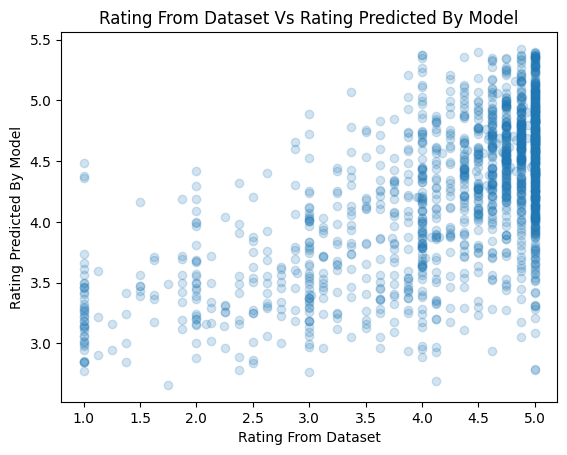

In [40]:
plt.scatter(Y_test, Y_pred, alpha=0.2)
plt.xlabel('Rating From Dataset')
plt.ylabel('Rating Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Rating From Dataset Vs Rating Predicted By Model")

# Random Forest:

Let's fit Random forest regressor to the dataset to see if can improve the R-squared value even more:

In [41]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
  
# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
  
# fit the regressor with x and y data
regressor.fit(X_train, Y_train)  

RandomForestRegressor(random_state=0)

Predicting a new result:

In [42]:
Y_pred = regressor.predict(X_test)  # test the output by changing values

Reporting mean squared error and R-2 score:

In [43]:
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error = {mse}")

test_set_r2 = r2_score(Y_test, Y_pred)
print(f"R-Squared = {test_set_r2}")

Mean Squared Error = 0.572035684052662
R-Squared = 0.43101493698694837


# Predicted against actual Y plot

Text(0.5, 1.0, 'Rating From Dataset Vs Rating Predicted By Model')

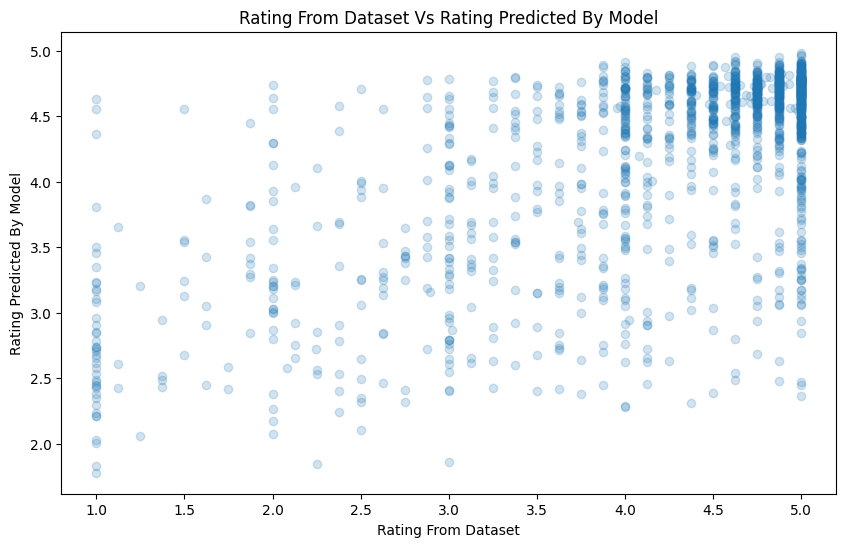

In [44]:
plt.scatter(Y_test, Y_pred, alpha=0.2)
plt.xlabel('Rating From Dataset')
plt.ylabel('Rating Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Rating From Dataset Vs Rating Predicted By Model")

# Gradient Boosting

Let's try the Gradient Boosting here:

In [45]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
print(f"Mean Squared Error = {mean_squared_error(Y_test, Y_pred)}")
print(f"R-Squared = {r2_score(Y_test, Y_pred)}")

Mean Squared Error = 0.5519593529266892
R-Squared = 0.4509842026276053


# Predicted against actual Y plot

Text(0.5, 1.0, 'Rating From Dataset Vs Rating Predicted By Model')

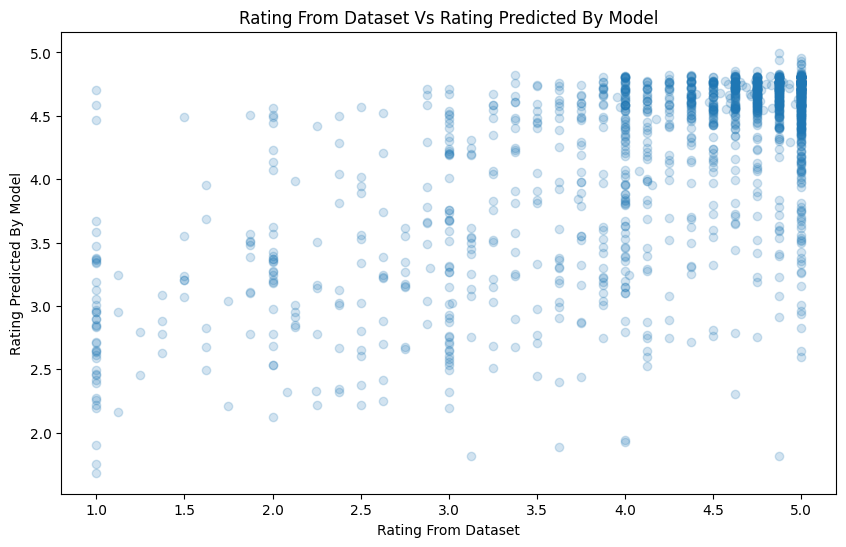

In [46]:
plt.scatter(Y_test, Y_pred, alpha=0.2)
plt.xlabel('Rating From Dataset')
plt.ylabel('Rating Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Rating From Dataset Vs Rating Predicted By Model")

# Further Evaluations

Let's see how well the model fits the data when it comes to prediction of the Car_Make level ratings. For that we need to keep the Car_Make in our dataset datarame; fit the regression on individual reviews and then calulate the average mean squared error and R-squared in the Car_Make level:

In [47]:
pd.set_option("display.max_colwidth", 10000)
agg_merged_keywords_review_df = merged_keywords_review_df.drop_duplicates(['Review_Title','sentiment.score']).groupby(["Review_Title"]).agg({
                       'sentiment.score': 'mean',
                       'emotion.sadness': 'mean',
                       'emotion.joy': 'mean',
                       'emotion.fear': 'mean',
                       'emotion.disgust': 'mean',
                       'emotion.anger': 'mean',
                       'Rating\r': 'first',
                       'Car_Make': 'first',
                       'Review_Content': 'first'
})
agg_merged_keywords_review_df.head(10)

,sentiment.score,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,Rating\r,Car_Make,Review_Content
Review_Title,,,,,,,,,
1 sweet R32,0.649825,0.151543,0.532162,0.067859,0.018501,0.112994,4.875,Volkswagen,"1 sweet R32: I was looking into buying a Subaru WRX \rSTI, but after two test drives in each \rand reading as many \rRoad&Track,Car&Driver,and any other \rinfo I could find I desided to go with \rthe R32. I traded in my 2003 GTI VR6 \rthat had 29,000 miles on it. That was a \rgreat car but this is a whole new \rbeast. Once you own an all wheel drive \rthere is just no going back. This car \rhandles like a dream, the seats are the \rbest I've ever been in. Cabin is put \rtogether very well and the pipes are \rcrazy. The climit control is awsome, \rheated seats are so sweet on those cold \rwinter days. I live in the central \rvalley of California so these tire are \rthe best. If there was one thing I \rwould change(give me a spare tire)!!!!!"
2002 Trans Am/Sunset Orange Metallic,0.148035,0.176322,0.465210,0.257064,0.032842,0.038908,4.625,pontiac,"2002 Trans Am/Sunset Orange Metallic: This Is Pontiac's most exciting vehicle \rof all time.It has so much performance \rthat it is a big disapointment that it \rwill be discontinued this year.The only \rarea that this vehicle does not excell \rin would be the fuel economy \rdepartment.I guess that if you can \rafford one of these dream cars, you \rreally dony worry about how far it will \rtravel on a tankfull of gas."
42 days of driving 8 days in the shop,-0.054126,0.206478,0.563466,0.114506,0.010082,0.082325,3.375,chrysler,42 days of driving 8 days in the shop : I was given the sebring for my 20th wedding anniversary. I have been in love with it for years and finally got it. After 42 days I blew most of the electrical system. It has been at the dealer for 8 days and they can not find the problem. Right now I am not very happy.
A great little car,0.503785,0.278575,0.470586,0.063823,0.015218,0.039688,4.875,kia,"A great little car: Bought my Spectra about one year ago, currently has about 18,000 miles on it. I have had absolutely no problems with it. I had cruise control added at the time of purchase, other than that it's stock. This is my daily driver, it's comfortable, reliable and gets decent mileage. The Spectra happens to be my second Kia, I have a Sedona van that has been to the dealer several times (however everything was covered by the warranty) it currently has 58,000 miles on it. The Spectra's a great handling car."
AWESOME FUN MY LITTLE TIGER,0.986029,0.007629,0.628312,0.013015,0.001452,0.024782,5.000,fiat,AWESOME FUN MY LITTLE TIGER: Abarth is ultimately more fun than my old mustang or Z a little power house that doesn't shy away from a fight love the engine growl and the kick more room than you think awesome bang for the buck .Fun the most fun than any car I have ever own worth every penny a pleasure to drive.
I LOVE my Focus,0.621983,0.074019,0.589196,0.111722,0.008124,0.066092,4.750,ford,"I LOVE my Focus: I LOVE my Focus. I've had it about 2 \ryears. It drives great, looks good, \rgets great gas milage and never slows \rdown. I'm even thinking of getting \ranother one on my next car purchase!"
Looks Good But Hunk Of Junk,-0.984622,0.144671,0.061358,0.060613,0.050494,0.116835,2.875,maserati,"Looks Good But Hunk Of Junk: This car is strictly ""looks only"", it is not reliable or even close to it.I have already sank $13,760 in repairs at only 23K miles.This is totally unacceptable for a $140K car when new.I am taking it to the auction next week to ""unload"" before it can empty my wallet again.But if you want a sharp car that sits good in the driveway - this is it!Just don't drive it anywhere!!"
Mr TACOMA,0.633803,0.122766,0.825653,0.034777,0.023124,0.030344,5.000,Toyota,Mr TACOMA: Great truck. The Handling is pretty \rnice and the engine is stronger. The V6 \rwith 3100 pounds can really make this \rtruck move.
Veracruz,0.591816,0.106981,0.524371,0.0914

In [48]:
train_set = agg_merged_keywords_review_df.sample(frac=0.75, random_state=0)
test_set = agg_merged_keywords_review_df.drop(train_set.index)

In [49]:
train_set.groupby("Car_Make").size()

Car_Make
AMGeneral          2
Acura            154
AlfaRomeo         60
AstonMartin       55
Audi             144
BMW              143
Bentley          102
Bugatti            7
Buick            134
Cadillac         140
Chevrolet        157
GMC              133
Honda            143
Toyota           130
Volkswagen       152
chrysler         136
dodge            142
ferrari          111
fiat             142
ford             138
genesis           48
hummer           149
hyundai          142
infiniti         134
isuzu            137
jaguar           128
jeep             127
kia              126
lamborghini       54
land-rover       141
lexus            125
lincoln          138
lotus            102
maserati         136
maybach           15
mazda            137
mclaren            1
mercedes-benz    133
mercury          131
mini             142
mitsubishi       118
nissan           125
pontiac          132
porsche          136
ram              152
rolls-royce       23
subaru           129
suzu

In [50]:
X_train = train_set.dropna().iloc[:, :6].values.reshape(-1, 6)  # values converts it into a numpy array
X_test = test_set.dropna().iloc[:, :6].values.reshape(-1, 6)  # values converts it into a numpy array
Y_train = train_set.dropna()['Rating\r'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y_test = test_set.dropna()['Rating\r'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

In [51]:
reg = GradientBoostingRegressor(random_state=0)  # create object for the class
reg.fit(X_train, Y_train)  # fit the model on the training data
Y_pred = reg.predict(X_test) # make predictions

In [52]:
predicted_y_with_na = np.zeros(len(test_set.index), dtype=object)
predicted_y_with_na[~test_set.isna().any(axis=1)] = Y_pred
test_set['Predicted_Y'] = predicted_y_with_na

In [53]:
agg_grouped_test_set = (
    test_set[sentiment_cols + ['Car_Make', 'Rating\r', 'Predicted_Y']]
    .groupby('Car_Make')
    .agg(['mean']))
agg_grouped_test_set

,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,sentiment.score,Rating\r,Predicted_Y
,mean,mean,mean,mean,mean,mean,mean,mean
Car_Make,,,,,,,,
AMGeneral,0.233502,0.416527,0.149416,0.030530,0.065171,0.021626,4.833333,4.264005
Acura,0.186803,0.467307,0.134082,0.020744,0.064254,0.330192,4.538690,4.455716
AlfaRomeo,0.179048,0.434307,0.101048,0.030507,0.088323,0.268080,4.187500,4.435494
AstonMartin,0.161465,0.532924,0.093979,0.030943,0.063027,0.470149,4.613636,4.631018
Audi,0.196609,0.490965,0.092430,0.021402,0.059860,0.303431,4.453431,4.421119
BMW,0.191940,0.474563,0.086499,0.024038,0.072675,0.243201,4.468750,4.354955
Bentley,0.187771,0.528449,0.089768,0.028513,0.057980,0.441103,4.239583,4.57587
Bugatti,0.188314,0.587727,0.055366,0.023677,0.054105,0.430882,4.750000,4.718716


In [54]:
# To get the number of reviews per Car Name:
test_set.groupby('Car_Make').nunique()

,sentiment.score,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,Rating\r,Review_Content,Predicted_Y
Car_Make,,,,,,,,,
AMGeneral,3,3,3,3,3,3,2,3,3
Acura,42,42,42,42,42,42,12,42,41
AlfaRomeo,16,16,16,16,16,16,4,16,16
AstonMartin,33,33,33,33,33,33,10,33,32
Audi,51,51,51,51,51,51,15,51,47
BMW,48,48,48,48,48,48,16,48,44
Bentley,36,36,36,36,36,36,14,36,32
Bugatti,1,1,1,1,1,1,1,1,1
Buick,53,53,53,53,53,53,19,53,51


In [55]:
# r2_score for predicted y and target y avg per group!
agg_r2_score = r2_score(agg_grouped_test_set['Rating\r'], agg_grouped_test_set['Predicted_Y'])
print(f"R-Squared = {agg_r2_score}")
agg_mse = mean_squared_error(agg_grouped_test_set['Rating\r'], agg_grouped_test_set['Predicted_Y'])
print(f"Mean Squared Error = {agg_mse}")

R-Squared = 0.5833818585164156
Mean Squared Error = 0.03221873091669909


As the mean_squared error shows when it comes to the average the model has fitted the data moderately well. The R-squareds shows a moderate effect size indicates that ~44% of the variability in the Rating cannot be explained by the model.

In [56]:
agg_grouped_test_set[['Rating\r', 'Predicted_Y']]

,Rating\r,Predicted_Y
,mean,mean
Car_Make,,
AMGeneral,4.833333,4.264005
Acura,4.538690,4.455716
AlfaRomeo,4.187500,4.435494
AstonMartin,4.613636,4.631018
Audi,4.453431,4.421119
BMW,4.468750,4.354955
Bentley,4.239583,4.57587
Bugatti,4.750000,4.718716


In [57]:
agg_grouped_test_set.dtypes

emotion.sadness  mean    float64
emotion.joy      mean    float64
emotion.fear     mean    float64
emotion.disgust  mean    float64
emotion.anger    mean    float64
sentiment.score  mean    float64
Rating\r         mean    float64
Predicted_Y      mean     object
dtype: object

y = 0.51x + 2.10


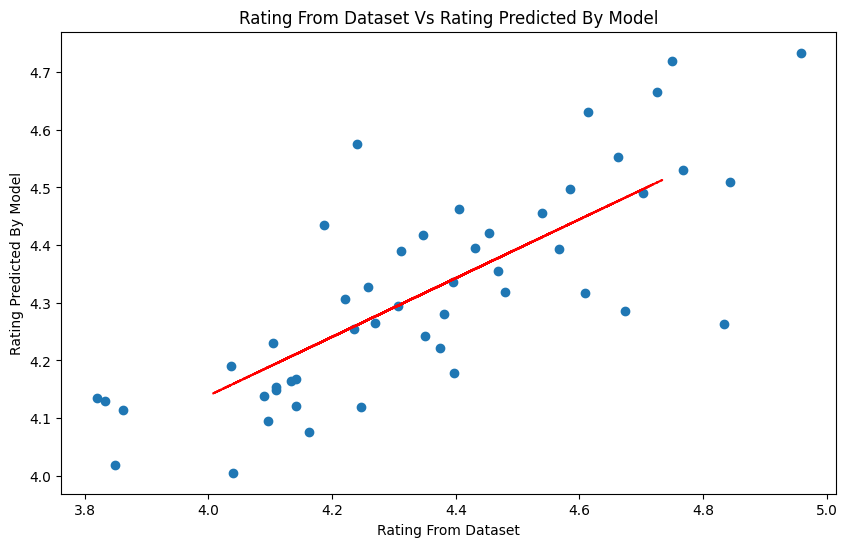

In [58]:
import matplotlib.pylab as pylab

# plot the data itself
pylab.plot(agg_grouped_test_set['Rating\r'],agg_grouped_test_set['Predicted_Y'],'o')
pylab.xlabel('Rating From Dataset')
pylab.ylabel('Rating Predicted By Model')

# calc the trendline
z = np.polyfit(np.squeeze(agg_grouped_test_set['Rating\r']),
               np.squeeze(agg_grouped_test_set['Predicted_Y'].astype(float)), 1)
p = np.poly1d(z)
pylab.plot(agg_grouped_test_set['Predicted_Y'],p(agg_grouped_test_set['Predicted_Y']),"r--")
pylab.title("Rating From Dataset Vs Rating Predicted By Model")
# the trendline equation:
print ("y = %.2fx + %.2f"%(z[0],z[1]))

The above results suggest a clear better fit for the model in average; showing that the Gradient Boosting Regressor model explains 74% of the fitted Car Make level Rating in the regression model.

# Conclusion

In this notebook we demonstrated how Text Extensions for Pandas can be used to perform Sentiment Analysis tasks. We started by loading our car reviews and passing it through Watson NLU service. We extracted the keywords and their corresponding sentiment and fine-grained emotion using the Watson NLU service. We used Text Extensions for Pandas to convert the Watson NLU output to pandas dataframe and calculated the reveiw-level sentiment and emotion. Using the resulted Pandas dataframe, we showed the correlation of Watson NLU's extracted features and user's Rating first and then developed the Univariate/Multivariate Regression, Random Forest, and Gradient Boosting models for predicting the Ratings for a given review. Finally we evaluated the ability of the model for predicting the sentiment for each car make.

This notebook also demonstrates how easy it is to use IBM Watson NLU, Pandas, Scikit Learn together to conduct exploratory analysis or predcition on your data.